In [80]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Non Negative Matrix Factorization (NMF)

## Outline

- General presentation
    - Problem definition
    - Usage
    - Applications
- Algorithm
    - Manual implementation
    - Scikit-learn implementation
- Examples
    - Recommender system
    - Image understanding
    - Text mining

## What is Non-negative Matrix Factorization?

### Problem definition

- __Inputs__: 
    - A data matrix $X$ ($n \times p$), with $n$ data points and a feature space in $p$ dimensions, containing only __non negative__ ($\geq 0$) values.
    - An positive integer $r$, smaller than $n$ and $p$.
- __Objective__: Finding two matrices $W$ ($n \times r$) and $H$ ($r \times p$), containing only non negative values, such that:
$$X \approx WH$$

### Usage
- As $r << min(n, p)$, the dimension is drastically reduced and we get a new feature space representing the initial data.
- Encourages sparsity.
- Once the factorization has been built, it is easy to apply standard learning algorithms on $W$ and $H$ to build classifications (e.g., K-means, Agglomerative) or new representations (e.g., PCA).

### Applications

Can you find examples of problems where all data are non-negative?

### Applications

- __Text mining__: 
    - The original data are the number of occurences of some words in a text.
    - NMF allows to automatically discover topics of the texts.
- __Computer vision__:
    - Original data are RGB images (integer coefficients between 0 and 255).
    - NMF allows to automatically discover basic components of an image.
- __Recommender systems__:
    - Original data are ratings of products (e.g., movies).
    - NMF allows to predict what next product a customer is going to like.
- etc.

## NMF Algorithm

### Formulation of the NMF problem

We want to minimize the _distance_ between $X$ and $WH$.

$$\text{Minimize}_{W, H} \;\; D(X, WH)$$

$$\text{subject to} \;\; w_{ij} \geq 0, \forall i \in \{1, ..., n\}, \forall j \in \{1, ..., r\}$$
$$\;\;\;\;\;\;\;\;\;\;\;\;\;\; h_{ij} \geq 0, \forall i \in \{1, ..., r\}, \forall j \in \{1, ..., p\}$$

The choice of the divergence function $D(., .)$ defines the $W$ and $H$ matrices obtained.

### Popular divergences for NMF

$D(M, \hat{M})$ is a _matrix distance_:

$$ D(M, \hat{M}) = \sum_{i=1}^{n} \sum_{j=1}^{p} d(m_{ij}, \hat{m}_{ij}),$$

and $d(x, y)$ is defined for all $x, y \geq 0$ as a $scalar distance$. Popular choices for $d(., .)$ are:
- __Euclidean distance__: $d(x, y) = (x - y)^2$. In this case, $D(., .)$ is the __Frobenius norm__.
- __Kullback-Leibler divergence__: $d(x, y) = x\log\frac{x}{y} - x + y$.
- __Itakura-Saito divergence__: $d(x, y) = \frac{x}{y} - \log \frac{x}{y} - 1$.

### Solving NMF using the multiplicative update rule

Solving the optimization problem presented above is difficult (NP-hard).\
To address this issue, many heuristics have been develop to find approximate solutions (local optima).

#### Multiplicative update rule
- Initialize $W$ and $H$ as non negative matrices: $W^0$ and $H^0$.
- Repeat until convergence:
    - Update $H$: 
    $$H^{n+1}_{ij} = H^n_{ij} \frac{((W^n)^TX)_{ij}}{((W^n)^TW^nH^n)_{ij}}$$
    - Update $W$: 
    $$W^{n+1}_{ij} = W^n_{ij} \frac{(X(H^{n+1})^T)_{ij}}{(W^nH^{n+1}(H^{n+1})^T)_{ij}}$$

#### Exercise: Compute manually the first $H$ update for the following matrix $X$

$$X = \begin{bmatrix}2 & 1 & 3\\
4 & 2 & 1\\
1 & 3 & 3 \end{bmatrix}$$

- The desired latent dimension is $2$.
- $W^0$ and $H^0$ are initialized full of ones.

#### Exercise: Write two functions for the two update steps.

- The first function __update_H__ can be tested using the matrices from the previous exercise.

In [81]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

X = np.array([[2,1,3],
              [4,2,1],
              [1,3,3]])

W = np.array([[1,1],
              [1,1],
              [1,1]])

H = np.array([[1,1,1], 
              [1,1,1]])

In [82]:
def update_H(W, H, X):
    WX = W.T.dot(X)
    WWH = W.T.dot(W.dot(H))

    return H * WX / WWH

new_H = update_H(W, H, X)
print(new_H)

[[1.16666667 1.         1.16666667]
 [1.16666667 1.         1.16666667]]


In [83]:
def update_W(W, H, X):
    XH = X.dot(H.T)
    WHH = W.dot(H.dot(H.T))

    return W * XH / WHH

new_W = update_W(W, new_H, X)
print(new_W)

[[0.91791045 0.91791045]
 [1.05223881 1.05223881]
 [1.02985075 1.02985075]]


#### Exercise: Compute the NMF of the matrix $X$ defined above.

- $W$ and $H$ can be initialized with small random values.
- The iterations can stop when the Frobenius norm (_np.linalg.norm_) between two updates of both $H$ and $W$ is less than $10^{-10}$

In [84]:
W = np.random.normal(0, 0.01, size=(3, 2))
H = np.random.normal(0, 0.01, size=(2, 3))

oldW, oldH = W + 1, H + 1
while (np.linalg.norm(H-oldH) > 1e-10) and (np.linalg.norm(W-oldW) > 1e-10):
    oldH, oldW = np.copy(H), np.copy(W)
    H = update_H(W, H, X)
    W = update_W(W, H, X)
    
print("Original data")
print(X)
print("\nReconstructed data")
print(W.dot(H))
print("\nSquared reconstruction error")
print(np.linalg.norm(W.dot(H) - X)**2)

Original data
[[2 1 3]
 [4 2 1]
 [1 3 3]]

Reconstructed data
[[1.75703089 1.95239992 2.40412317]
 [4.06198444 1.75703093 1.15201558]
 [1.15201564 2.40412313 3.37281525]]

Squared reconstruction error
1.9243227669664913


#### Exercise: Compute the NMF of $X$ using scikit-learn and compare the results.

- from sklearn.decomposition import NMF

In [85]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=2, init="random", solver="mu")
nmf.fit(X)
W = nmf.transform(X)
H = nmf.components_

print("Original data")
print(X)
print("\nReconstructed data")
print(W.dot(H))
print("\nSquared reconstruction error")
print(np.linalg.norm(W.dot(H) - X)**2)

Original data
[[2 1 3]
 [4 2 1]
 [1 3 3]]

Reconstructed data
[[1.75756263 1.95249096 2.40353133]
 [4.05031074 1.76746417 1.17616735]
 [1.15147193 2.40504668 3.37255837]]

Squared reconstruction error
1.9251417334764613


#### Initialization

Several approaches can be implemented regarding the initialization of $W$ and $H$.

- Several random initializations
- Non-negative double singular value decomposition (NNSVD)
- A classification (k-means) of either rows or columns
- etc.

## NMF examples

### Example 1: Text mining

In [86]:
from sklearn.datasets import fetch_20newsgroups

data, _ = fetch_20newsgroups(
    shuffle=True,
    random_state=1,
    remove=("headers", "footers", "quotes"),
    return_X_y=True)

In [87]:
example_text_id = np.random.randint(len(data))

print("Number of texts in the dataset:", len(data))
print("Example text: \n\n", data[example_text_id])

Number of texts in the dataset: 11314
Example text: 

 
/>
/>I always thought GD's  Fighter plants were in Long Island.  
/>
/No, Northrup has a plant on Long Island.

I don't think Northrup ever had a plant on Long Island.  The two main airframe
manufacturers there were (Fairchild)/Republic which closed its doors after the
T-46 cancellation, and Grumman (which is still hanging on last I time I called).
I think Sperry also started there.  If you're ever in the area check out the
Cradle of Aviation Museum at Mitchell field (now mostly parking lots behind the
Nassau Coliseum and the community college).  Good display of vehicles from Long
Island, including a LEM flight article.


In [88]:
# Convert text to TfIdf

from sklearn.feature_extraction.text import TfidfVectorizer

n_samples = 2000
n_features = 1000

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words="english")
tfidf_data = tfidf_vectorizer.fit_transform(data)

feature_names = tfidf_vectorizer.get_feature_names_out()

In [89]:
print("Number of texts:", tfidf_data.shape[0])
print("Number of TfIdf features:", tfidf_data.shape[1])

print("\nMost important words for example text:")
tfidf_data_print = tfidf_data[example_text_id].tocoo()
for i in range(len(tfidf_data_print.col)):
    print("%10s\t%s" % (feature_names[tfidf_data_print.col[i]], tfidf_data_print.data[i]))

Number of texts: 11314
Number of TfIdf features: 1000

Most important words for example text:
   started	0.2010180024632507
   thought	0.17531656318548028
      long	0.6342362661771658
      main	0.21396767909401695
      lots	0.21952957627084255
 community	0.2336883668031975
     field	0.22667823132333106
   display	0.212634696384229
   article	0.18871718019760203
 including	0.19256203011903922
    called	0.17143808949204734
     check	0.19549633017564982
      good	0.12916524538471544
      time	0.12481858660493886
      area	0.1932772620225611
       don	0.11232053196274291
     think	0.24264902379648115


In [120]:
nmf = NMF(n_components=10, beta_loss="kullback-leibler", init="nndsvda", 
          solver="mu", max_iter=1000, alpha=0.1, l1_ratio=0.5)
nmf.fit(tfidf_data)

W = nmf.transform(tfidf_data)
H = nmf.components_

/home/joris/Softwares/miniconda3/envs/clustering_lectures/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


In [124]:
def plot_topics(H):
    n_top_words = 10
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for i in range(H.shape[0]):
        topic = H[i, :]
        top_features = topic.argsort()[: -n_top_words - 1 : -1]
        top_features_names = [feature_names[j] for j in top_features]
        top_features_scores = [topic[j] for j in top_features]

        ax = axes[i]
        ax.barh(top_features_names, top_features_scores, height=0.7)
        ax.set_title(f"Topic {i+1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

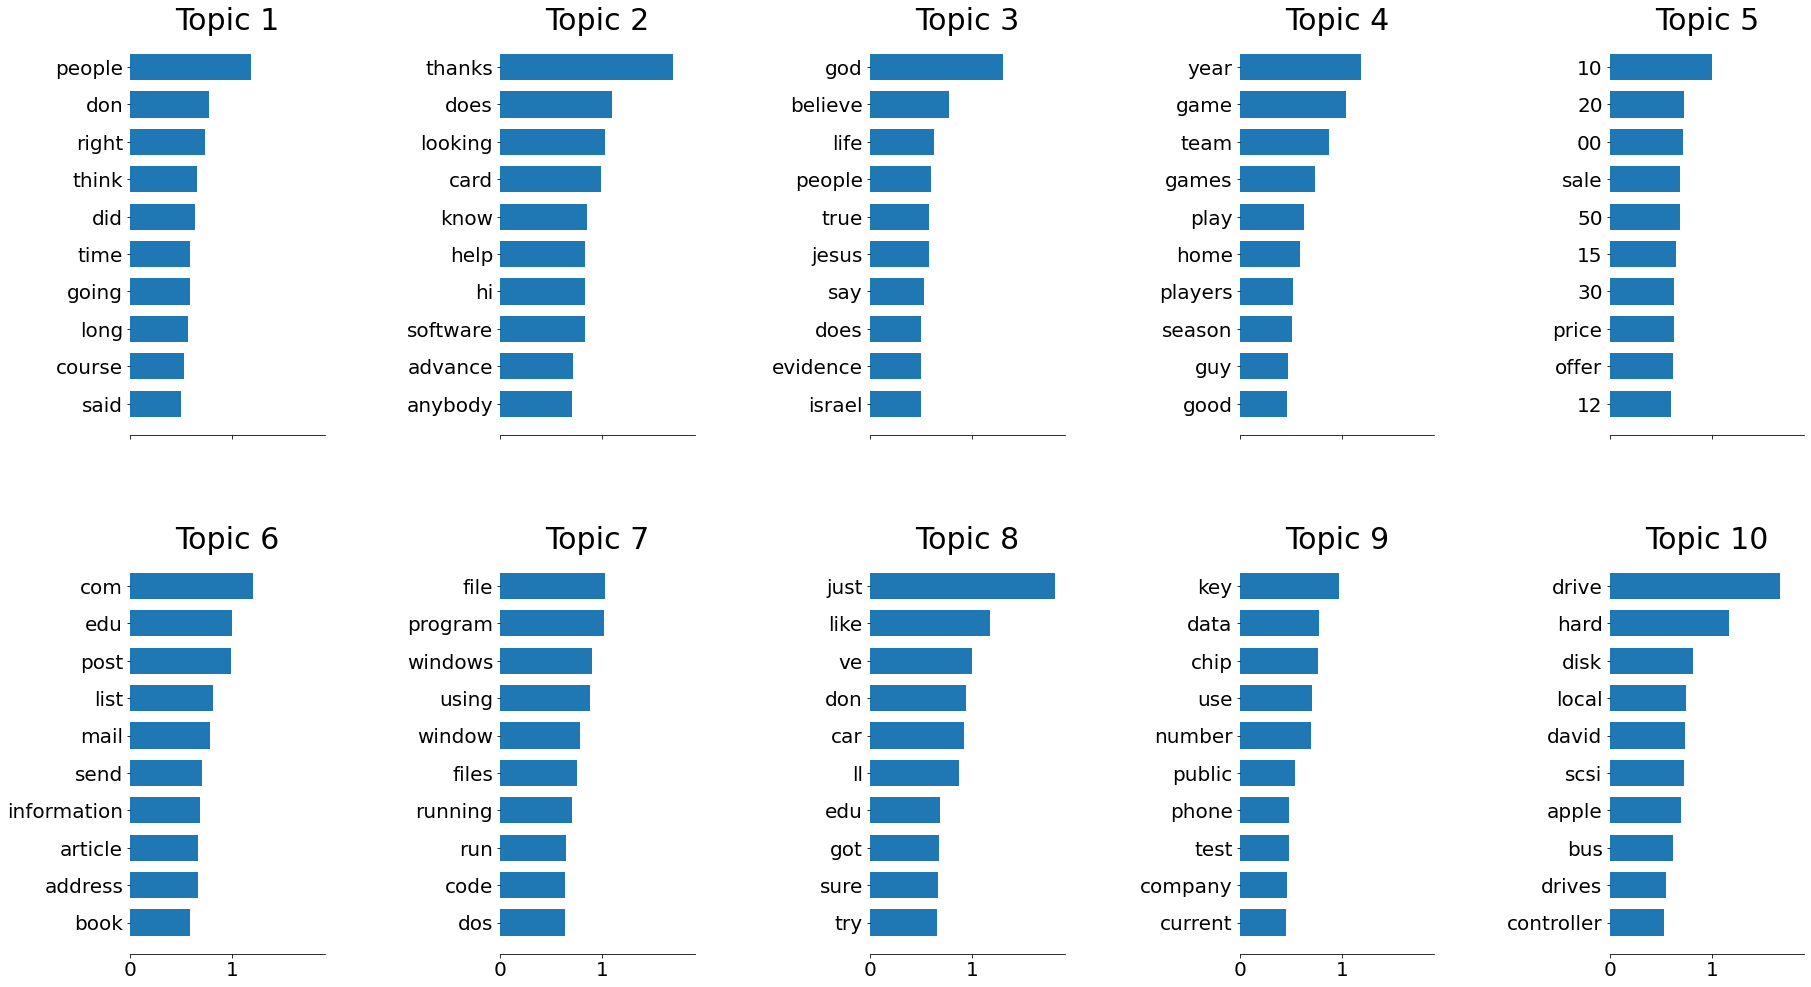

In [125]:
plot_topics(H)

### Example 2: Image understanding

In [154]:
from sklearn.datasets import fetch_olivetti_faces

image_shape = (64, 64)

faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True)
n_samples, n_features = faces.shape

print("The dataset is composed of %i face images" % n_samples)
print("Images contain %i features (64x64 images)" % n_features)

The dataset is composed of 400 face images
Images contain 4096 features (64x64 images)


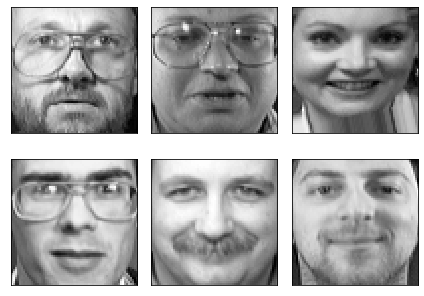

In [155]:
# Visualize first images

n_row, n_col = 2, 3
plt.figure(figsize=(2.0 * n_col, 2.26 * n_row))
for i in range(len(faces[:n_row*n_col])):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(faces[i].reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()
plt.show()

In [156]:
nmf = NMF(n_components=6, init="nndsvda", tol=5e-3)
nmf.fit(faces)

W = nmf.transform(faces)
H = nmf.components_

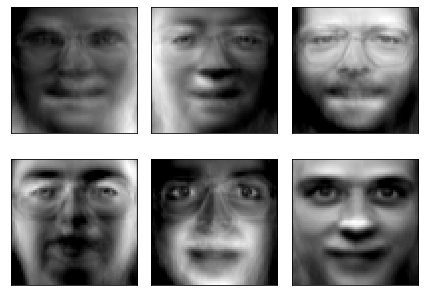

In [157]:
# Visualize image components

plt.figure(figsize=(2.0 * n_col, 2.26 * n_row))
for i in range(len(faces[:n_row*n_col])):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(H[i].reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()
plt.show()

#### Exercise: 
- Display the reconstructed images corresponding to the first six images
- Are the images realistic?
- Try again with more latent variables. (20?)

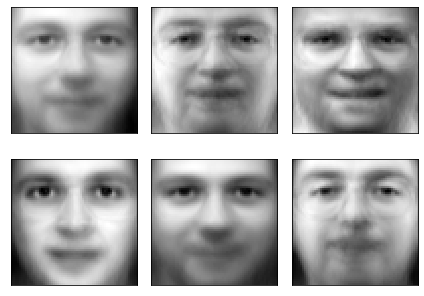

In [158]:
# Reconstructed images

reconstructed_images = W.dot(H)
plt.figure(figsize=(2.0 * n_col, 2.26 * n_row))
for i in range(len(reconstructed_images[:n_row*n_col])):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(reconstructed_images[i].reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()
plt.show()

In [235]:
nmf = NMF(n_components=20, init="nndsvda", tol=5e-3)
nmf.fit(faces)

W = nmf.transform(faces)
H = nmf.components_

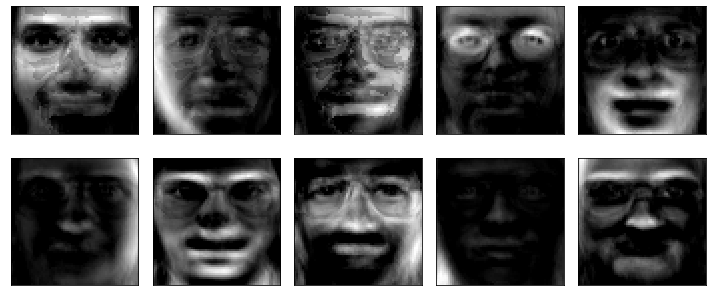

In [236]:
plt.figure(figsize=(2.0 * 5, 2.26 * 2))
for i in range(len(faces[:10])):
    plt.subplot(2, 5, i + 1)
    plt.imshow(H[i].reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()
plt.show()

Reconstructed images


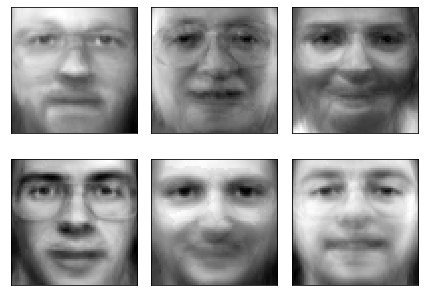

Original images


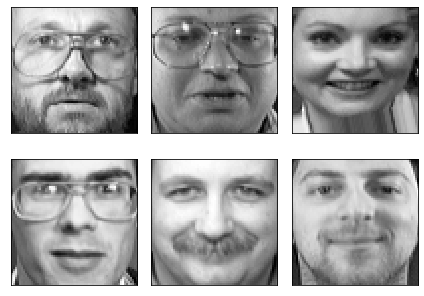

In [237]:
print("Reconstructed images")

reconstructed_images = W.dot(H)
plt.figure(figsize=(2.0 * n_col, 2.26 * n_row))
for i in range(len(reconstructed_images[:n_row*n_col])):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(reconstructed_images[i].reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()
plt.show()

print("Original images")

plt.figure(figsize=(2.0 * n_col, 2.26 * n_row))
for i in range(len(faces[:n_row*n_col])):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(faces[i].reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()
plt.show()

#### Exercise:

- Select an image at random in the dataset
- Display the top 3 characteristic images used to encode it?
- What is the percentage of explained reconstruction corresponding to these 3 characteristic images?

Original image


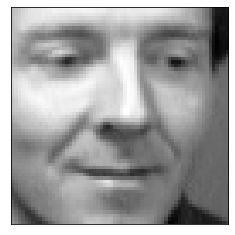

Reconstructed image


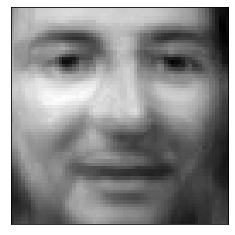

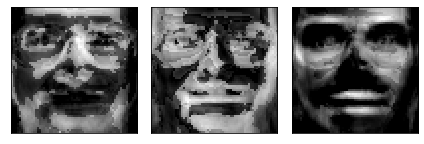

Explained reconstruction:  0.74697196


In [246]:
index = np.random.randint(faces.shape[0])
print("Original image")
plt.imshow(faces[index].reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest")
plt.xticks(())
plt.yticks(())
plt.show()

print("Reconstructed image")
plt.imshow(W.dot(H)[index].reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest")
plt.xticks(())
plt.yticks(())
plt.show()

sorted_scores = np.argsort(-W[index, :], )
plt.figure(figsize=(2.0 * 3, 2.26 * 1))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(H[sorted_scores[i]].reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()
plt.show()

print("Explained reconstruction: ", np.sum(W[index, sorted_scores[:3]]))

### Example 3: Recommender system

Next hands-on!

In [113]:
import pandas as pd

data = pd.read_csv("Data/recom-jouet.dat", sep=" ")

data

,Cacahuet,Chips,Vin,Biere,Champ,Olive,Pepsi,Orange,Gateau,Fromage,Perrier,Pizza,Muscat,Quiche,Coca
Jean,1,0,0,2,1,4,6,0,5,2,0,0,1,2,0
Julie,4,0,5,2,1,4,0,0,5,1,1,0,0,1,3
Brice,0,0,0,2,1,4,2,1,4,0,4,2,0,0,2
George,3,0,0,1,1,0,6,0,5,0,2,1,3,2,0
Rose,3,0,0,2,1,4,1,0,5,0,1,0,3,2,0
Colette,0,3,3,4,0,2,4,5,6,2,0,1,0,1,0
Aline,3,0,0,2,1,4,6,0,5,0,5,3,0,2,0
Marie,3,6,0,0,0,0,0,0,5,2,2,1,6,2,0
Albert,0,3,3,0,0,2,2,2,1,0,5,0,0,2,4
Kevin,2,0,0,2,2,0,3,0,3,2,1,0,4,2,0


In [159]:
nmf = NMF(n_components=5)

nmf.fit(data)
W = nmf.transform(data)
H = nmf.components_

/home/joris/Softwares/miniconda3/envs/clustering_lectures/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


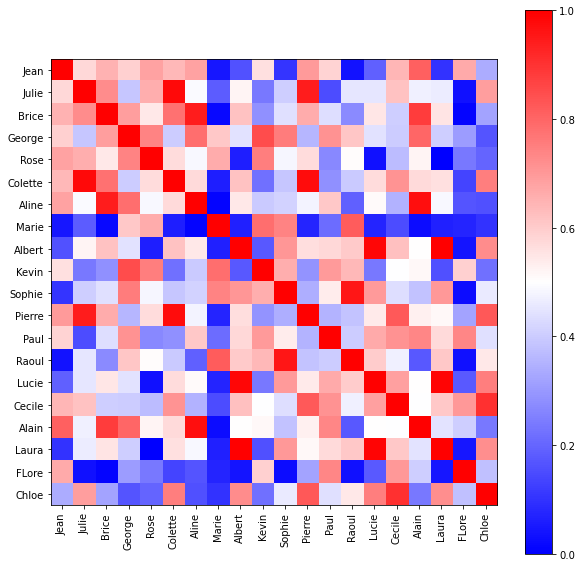

In [160]:
from sklearn.metrics.pairwise import cosine_similarity

users_similarity = cosine_similarity(W)

plt.figure(figsize=(10,10))
plt.imshow(users_similarity, cmap="bwr")
plt.colorbar()
plt.xticks(ticks=range(len(data.index.values)), labels=data.index.values, rotation="vertical")
plt.yticks(ticks=range(len(data.index.values)), labels=data.index.values)
plt.show()

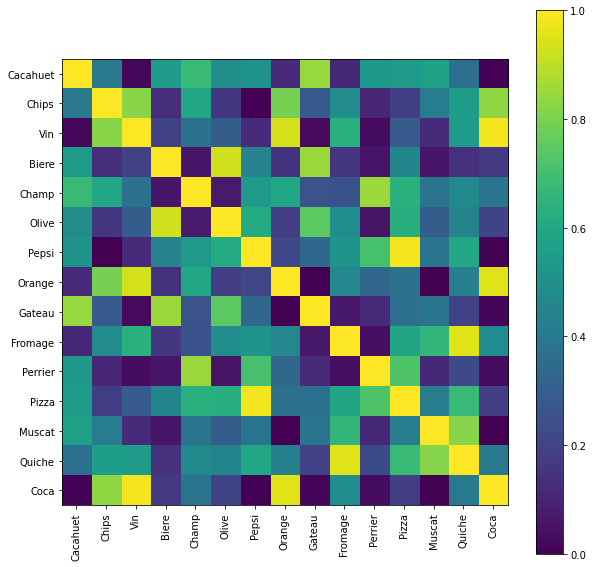

In [161]:
products_similarity = cosine_similarity(H.T)

plt.figure(figsize=(10,10))
plt.imshow(products_similarity)
plt.colorbar()
plt.xticks(ticks=range(len(data.columns.values)), labels=data.columns.values, rotation="vertical")
plt.yticks(ticks=range(len(data.columns.values)), labels=data.columns.values)
plt.show()

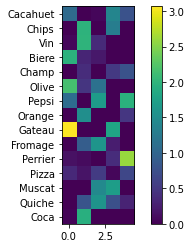

In [162]:
plt.imshow(H.T)
plt.colorbar()
plt.yticks(ticks=range(len(data.columns.values)), labels=data.columns.values)
plt.show()

In [187]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=5, compute_distances=True)
clusters_reduced = agg.fit_predict(H.T)

# plt.scatter(np.arange(agg.distances_.shape[0], 0, -1), agg.distances_)
# plt.show()

Plot Dendrogram


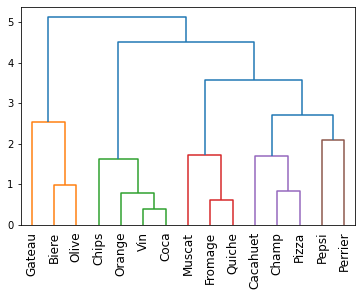

In [197]:
from scipy.cluster.hierarchy import dendrogram

print("Plot Dendrogram")

children = agg.children_
distances = agg.distances_
n_observations = np.arange(2, children.shape[0]+2)

linkage_matrix = np.c_[children, distances, n_observations]

thresh = 0.5 * (agg.distances_[-4] + agg.distances_[-5])
dendrogram(linkage_matrix, labels=data.columns.values, leaf_rotation=90, color_threshold=thresh)
plt.show()

In [192]:
print(agg.distances_)

[0.37324486 0.60305539 0.79118005 0.8274065  0.9818171  1.62685736
 1.68440288 1.72492834 2.08379185 2.53740626 2.70658985 3.5694038
 4.50105315 5.11329653]


In [183]:
agg = AgglomerativeClustering(n_clusters=5, compute_distances=True)
clusters_full_data = agg.fit_predict(data.T)

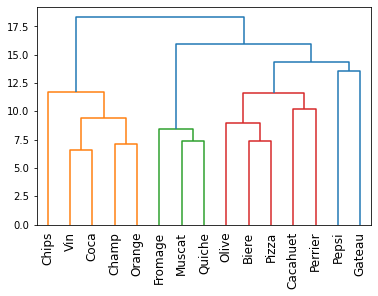

In [184]:
children = agg.children_
distances = agg.distances_
n_observations = np.arange(2, children.shape[0]+2)

linkage_matrix = np.c_[children, distances, n_observations]

dendrogram(linkage_matrix, labels=data.columns.values, leaf_rotation=90)
plt.show()

In [185]:
from sklearn.metrics import normalized_mutual_info_score

print(normalized_mutual_info_score(clusters_reduced, clusters_full_data))

0.7117182527586893
